In [1]:
import os
import time
import matplotlib.pyplot as plt

import utils
from collections import Counter
from tqdm import tqdm
import numpy as np
import tarfile
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.datasets.utils import download_url
from sklearn.metrics import roc_auc_score, roc_curve, auc

torch.manual_seed(1991)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# General Functions

In [ ]:
# Custom class for GRU model used with three datasets below
class MyGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=2, n_layers=4, double_inp_size=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        if double_inp_size:
            input_dim = input_dim * 2

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, 
                         batch_first=True, dropout=0.3 if n_layers > 1 else 0)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x, mask=None):
        if mask is not None:
            x = torch.cat([x, mask], dim=-1) 
        
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.gru(x, h0)

        out = self.fc(out[:, -1, :])
        return out

In [3]:
# Define training loop
def train_epoch(model, train_loader, loss_f, opt, device, epoch, EPOCHS, is_phys=True):
    model.train()
    running_train_loss = []
    correct_predictions = 0

    train_loop = tqdm(train_loader, leave=False)
    for batch in train_loop:
        if is_phys:
            data = batch["observed_data"].to(device)
            mask = batch["observed_mask"].to(device)
            labels = batch["labels"].squeeze()
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
        else:
            data = batch['image'].to(device)
            labels = batch['label'].reshape(-1).to(torch.int32)
            labels = torch.eye(10)[labels].to(device)
            mask = None

        # Forward pass
        logits = model(data, mask=mask)
        loss = loss_f(logits, labels)

        # Backward pass
        opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

        # Track metrics
        running_train_loss.append(loss.item())
        preds = torch.argmax(logits, dim=1)
        if is_phys:
            correct_predictions += torch.sum(preds == labels).item()
        else:
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()

        # Update progress bar
        mean_train_loss = sum(running_train_loss) / len(running_train_loss)

        train_loop.set_description(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {mean_train_loss:.4f}")

    # Calculate epoch metrics
    train_accuracy = correct_predictions / len(train_loader.dataset)
    
    return mean_train_loss, train_accuracy

# Define validation loop
def validate(model, val_loader, loss_f, device, is_phys=True):
    model.eval()
    running_val_loss = []
    correct_predictions = 0
    val_scores, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            if is_phys:
                data = batch["observed_data"].to(device)
                mask = batch["observed_mask"].to(device)
                labels = batch["labels"].squeeze()
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
            else:
                data = batch['image'].to(device)
                labels = batch['label'].reshape(-1).to(torch.int32)
                labels = torch.eye(10)[labels].to(device)
                mask = None

            # Forward pass
            logits = model(data, mask=mask)
            loss = loss_f(logits, labels)

            # Track metrics
            running_val_loss.append(loss.item())
            preds = torch.argmax(logits, dim=1)
            if is_phys:
                correct_predictions += torch.sum(preds == labels).item()
                val_scores.append(logits[:, 1].detach().cpu())
                val_labels.append(labels.detach().cpu())
            else:
                correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
                val_scores.append(logits.detach().cpu())
                val_labels.append(labels.detach().cpu())
         

    # Calculate validation metrics
    mean_val_loss = sum(running_val_loss) / len(running_val_loss)
    val_accuracy = correct_predictions / len(val_loader.dataset)
    val_scores = torch.cat(val_scores)
    val_labels = torch.cat(val_labels)
    
    val_auroc = roc_auc_score(val_labels, val_scores)
    
    return mean_val_loss, val_accuracy, val_auroc

# Define function to predict using the best model
def best_model_predict(model, model_path, test_loader, is_phys=True):
    
    # Load the saved weights
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    
    # Set model to evaluation mode
    model.eval()  
    all_labels = []  
    all_predictions = []
    all_scores = []
    correct_predictions = 0

    # Disable gradient calculation for inference
    with torch.no_grad():
        for batch in test_loader:
            # Move data to device
            if is_phys:
                data = batch["observed_data"].to(device)
                mask = batch["observed_mask"].to(device)
                labels = batch["labels"].squeeze()
                labels = labels.type(torch.LongTensor)
                labels = labels.to(device)
            else:
                data = batch['image'].to(device)
                labels = batch['label'].reshape(-1).to(torch.int32)
                labels = torch.eye(10)[labels].to(device)
                mask = None
            
            # Forward pass
            logits = model(data, mask=mask)
            
            # Get predictions
            preds = torch.argmax(logits, dim=1)

            # Calculate accuracy and store predictions
            if is_phys:
                correct_predictions += torch.sum(preds == labels).item()
                all_predictions.extend(preds.detach().cpu().numpy())
                all_scores.extend(logits[:, 1].detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
            else:
                correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
                all_predictions.extend(preds.detach().cpu().numpy())
                all_scores.extend(logits.detach().cpu().numpy())
                all_labels.extend(labels.detach().cpu().numpy())
    
    # Calculate overall accuracy
    accuracy = correct_predictions / len(test_loader.dataset)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    return np.array(all_labels), np.array(all_predictions), np.array(all_scores)

In [4]:
# Copied from stepik course on pytorch
class EarlyStopping:
    def __init__(self, mode='min', patience=10, threshold=10e-5, threshold_mode='rel'):
        if mode not in ('min', 'max'):
            raise ValueError(f'Parameter mode can be either `min` or `max`')
        if threshold_mode not in ('rel', 'abs'):
            raise ValueError(f'Parameter threshold_mode can be either `rel` or `ads`')
        if not isinstance(patience, int):
            raise ValueError(f'Parameter patience must be integer')
        if not isinstance(threshold, float):
            raise ValueError(f'Parameter threshold must be float')
        if threshold >= 1.0:
            raise ValueError('Parameter threshold must be less or equal to 1.0')
        
        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None

    def __call__(self, tracked_parameter):
        current = float(tracked_parameter)
        if self.best is None:
            self.best = current
            return False
        
        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1

        if self.count >= self.patience:
            self.count = 0
            return True
        return False
    
    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best - best * self.threshold
        
        elif self.mode == 'min' and self.threshold_mode == 'abs':
            return current < best - self.threshold
          
        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best + best * self.threshold
        
        elif self.mode == 'max' and self.threshold_mode == 'abs':
            return current > best + self.threshold        

In [5]:
def plot_roc(y_true, y_proba, model_name, color=None, lw=2, ax=None):
    # Adapted from sklearn manual
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5), dpi=150)

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(
        fpr,
        tpr,
        color=color,
        lw=lw,
        label=f"{model_name} (AUC = {roc_auc:.3g})",
    )
    ax.plot([0, 1], [0, 1], color="navy", lw=lw * 0.7, linestyle="--", alpha=0.7)
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    return ax

In [6]:
from sklearn.preprocessing import label_binarize

def plot_macro_roc(y_true, y_scores, model_name, n_classes=10, color=None, lw=2, ax=None):

    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5), dpi=150)

    # Check if y_true is already binarized
    if y_true.ndim == 2:
        y_true_bin = y_true
        print("Labels are already binarized")
    elif y_true.ndim == 1:
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        print("Labels binarized from class indices")
    else:
        raise ValueError("y_true must be either 1D array of class indices or 2D binarized array!")
    
    # Compute ROC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    macro_auc = auc(all_fpr, mean_tpr)
    
    # Plot
    ax.plot(all_fpr, mean_tpr, 
             label=f"{model_name} (Macro_AUC = {macro_auc:.3g})",
             color=color, lw=lw)
    ax.plot([0, 1], [0, 1], color="navy", lw=lw * 0.7, linestyle="--", alpha=0.7)
    
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    return ax

# PhysioNet data

### Data preparation

In [7]:
# Adapted from: https://github.com/YuliaRubanova/latent_ode

# get minimum and maximum for each feature across the whole dataset
def get_data_min_max(records):
	device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

	data_min, data_max = None, None
	inf = torch.Tensor([float("Inf")])[0].to(device)

	for b, (record_id, tt, vals, mask, labels) in enumerate(records):
		n_features = vals.size(-1)

		batch_min = []
		batch_max = []
		for i in range(n_features):
			non_missing_vals = vals[:,i][mask[:,i] == 1]
			if len(non_missing_vals) == 0:
				batch_min.append(inf)
				batch_max.append(-inf)
			else:
				batch_min.append(torch.min(non_missing_vals))
				batch_max.append(torch.max(non_missing_vals))

		batch_min = torch.stack(batch_min)
		batch_max = torch.stack(batch_max)

		if (data_min is None) and (data_max is None):
			data_min = batch_min
			data_max = batch_max
		else:
			data_min = torch.min(data_min, batch_min)
			data_max = torch.max(data_max, batch_max)

	return data_min, data_max


def variable_time_collate_fn(batch, device = torch.device("cuda:0"), data_type = "train", 
	data_min = None, data_max = None):
	"""
	Expects a batch of time series data in the form of (record_id, tt, vals, mask, labels) where
		- record_id is a patient id
		- tt is a 1-dimensional tensor containing T time values of observations.
		- vals is a (T, D) tensor containing observed values for D variables.
		- mask is a (T, D) tensor containing 1 where values were observed and 0 otherwise.
		- labels is a list of labels for the current patient, if labels are available. Otherwise None.
	Returns:
		combined_tt: The union of all time observations.
		combined_vals: (M, T, D) tensor containing the observed values.
		combined_mask: (M, T, D) tensor containing 1 where values were observed and 0 otherwise.
	"""
	D = batch[0][2].shape[1]
	combined_tt, inverse_indices = torch.unique(torch.cat([ex[1] for ex in batch]), sorted=True, return_inverse=True)
	combined_tt = combined_tt.to(device)

	offset = 0
	combined_vals = torch.zeros([len(batch), len(combined_tt), D]).to(device)
	combined_mask = torch.zeros([len(batch), len(combined_tt), D]).to(device)
	
	combined_labels = None
	N_labels = 1

	combined_labels = torch.zeros(len(batch), N_labels) + torch.tensor(float('nan'))
	combined_labels = combined_labels.to(device = device)
	
	for b, (record_id, tt, vals, mask, labels) in enumerate(batch):
		tt = tt.to(device)
		vals = vals.to(device)
		mask = mask.to(device)
		if labels is not None:
			labels = labels.to(device)

		indices = inverse_indices[offset:offset + len(tt)]
		offset += len(tt)

		combined_vals[b, indices] = vals
		combined_mask[b, indices] = mask

		if labels is not None:
			combined_labels[b] = labels

	combined_vals, _, _ = utils.normalize_masked_data(combined_vals, combined_mask, 
		att_min = data_min, att_max = data_max)

	if torch.max(combined_tt) != 0.:
		combined_tt = combined_tt / torch.max(combined_tt)
		
	data_dict = {
		"data": combined_vals, 
		"time_steps": combined_tt,
		"mask": combined_mask,
		"labels": combined_labels}

	data_dict = utils.split_and_subsample_batch(data_dict, data_type = data_type)
	return data_dict


class PhysioNet(Dataset):

	urls = [
		'https://physionet.org/files/challenge-2012/1.0.0/set-a.tar.gz?download',
		'https://physionet.org/files/challenge-2012/1.0.0/set-b.tar.gz?download',
	]

	outcome_urls = ['https://physionet.org/files/challenge-2012/1.0.0/Outcomes-a.txt',
				 	'https://physionet.org/files/challenge-2012/1.0.0/Outcomes-b.txt']

	params = [
		'Age', 'Gender', 'Height', 'ICUType', 'Weight', 'Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN',
		'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg',
		'MAP', 'MechVent', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Platelets', 'RespRate',
		'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC'
	]

	params_dict = {k: i for i, k in enumerate(params)}

	labels = [ "SAPS-I", "SOFA", "Length_of_stay", "Survival", "In-hospital_death" ]
	labels_dict = {k: i for i, k in enumerate(labels)}

	def __init__(self, root, train=True, download=False,
		quantization = 0.1, n_samples = None, device = torch.device("cuda:0")):

		self.root = root
		self.train = train
		self.reduce = "average"
		self.quantization = quantization

		if download:
			self.download()

		if not self._check_exists():
			raise RuntimeError('Dataset not found. You can use download=True to download it')

		if self.train:
			data_file = self.training_file
		else:
			data_file = self.test_file
		
		if device == torch.device("cpu"):
			self.data = torch.load(os.path.join(self.processed_folder, data_file), map_location='cpu', weights_only=False)
			self.labels = torch.load(os.path.join(self.processed_folder, self.label_file), map_location='cpu', weights_only=False)
		else:
			self.data = torch.load(os.path.join(self.processed_folder, data_file), weights_only=False)
			self.labels = torch.load(os.path.join(self.processed_folder, self.label_file), weights_only=False)

		if n_samples is not None:
			self.data = self.data[:n_samples]
			self.labels = self.labels[:n_samples]
		
		# Load correct outcomes file
		outcome_file = 'Outcomes-a.pt' if self.train else 'Outcomes-b.pt'
		self.outcomes = torch.load(os.path.join(self.processed_folder, outcome_file), 
								map_location=device, weights_only=False)


	def download(self):
		if self._check_exists():
			return

		self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

		os.makedirs(self.raw_folder, exist_ok=True)
		os.makedirs(self.processed_folder, exist_ok=True)

		# Process outcomes separately
		for url in self.outcome_urls:
			filename = url.rpartition('/')[2]
			download_url(url, self.raw_folder, filename, None)

			txtfile = os.path.join(self.raw_folder, filename)
			outcomes = {}
			
			with open(txtfile) as f:
				lines = f.readlines()
				for l in lines[1:]:  # Skip header
					l = l.rstrip().split(',')
					record_id = l[0]
					labels = np.array(l[1:]).astype(float)
					# Store mortality label (last column)
					outcomes[record_id] = torch.tensor(labels[4]).float()

			# Save as Outcomes-a.pt or Outcomes-b.pt
			outcome_name = filename.split('.')[0]
			torch.save(outcomes, 
					os.path.join(self.processed_folder, f"{outcome_name}.pt"))


		for url in self.urls:
			filename = url.rpartition('/')[2]
			download_url(url, self.raw_folder, filename, None)
			tar = tarfile.open(os.path.join(self.raw_folder, filename), "r:gz")
			tar.extractall(self.raw_folder)
			tar.close()

			print('Processing {}...'.format(filename))

			dirname = os.path.join(self.raw_folder, filename.split('.')[0])
			patients = []
			total = 0
			for txtfile in os.listdir(dirname):
				record_id = txtfile.split('.')[0]
				with open(os.path.join(dirname, txtfile)) as f:
					lines = f.readlines()
					prev_time = 0
					tt = [0.]
					vals = [torch.zeros(len(self.params)).to(self.device)]
					mask = [torch.zeros(len(self.params)).to(self.device)]
					nobs = [torch.zeros(len(self.params))]
					for l in lines[1:]:
						total += 1
						time, param, val = l.split(',')
						# Time in hours
						time = float(time.split(':')[0]) + float(time.split(':')[1]) / 60.
						# round up the time stamps (up to 6 min by default)
						# used for speed -- we actually don't need to quantize it in Latent ODE
						time = round(time / self.quantization) * self.quantization

						if time != prev_time:
							tt.append(time)
							vals.append(torch.zeros(len(self.params)).to(self.device))
							mask.append(torch.zeros(len(self.params)).to(self.device))
							nobs.append(torch.zeros(len(self.params)).to(self.device))
							prev_time = time

						if param in self.params_dict:
							#vals[-1][self.params_dict[param]] = float(val)
							n_observations = nobs[-1][self.params_dict[param]]
							if self.reduce == 'average' and n_observations > 0:
								prev_val = vals[-1][self.params_dict[param]]
								new_val = (prev_val * n_observations + float(val)) / (n_observations + 1)
								vals[-1][self.params_dict[param]] = new_val
							else:
								vals[-1][self.params_dict[param]] = float(val)
							mask[-1][self.params_dict[param]] = 1
							nobs[-1][self.params_dict[param]] += 1
						else:
							assert param == 'RecordID', 'Read unexpected param {}'.format(param)
				tt = torch.tensor(tt).to(self.device)
				vals = torch.stack(vals)
				mask = torch.stack(mask)

				labels = None
				if record_id in outcomes:
					# Only training set has labels
					labels = outcomes[record_id]
					# # Out of 5 label types provided for Physionet, take only the last one -- mortality
					# labels = labels[4]

				patients.append((record_id, tt, vals, mask, labels))

			torch.save(
				patients,
				os.path.join(self.processed_folder, 
					filename.split('.')[0] + "_" + str(self.quantization) + '.pt')
			)
				
		print('Done!')

	def _check_exists(self):
		for url in self.urls:
			filename = url.rpartition('/')[2]

			if not os.path.exists(
				os.path.join(self.processed_folder, 
					filename.split('.')[0] + "_" + str(self.quantization) + '.pt')
			):
				return False
		return True

	@property
	def raw_folder(self):
		return os.path.join(self.root, self.__class__.__name__, 'raw')

	@property
	def processed_folder(self):
		return os.path.join(self.root, self.__class__.__name__, 'processed')

	@property
	def training_file(self):
		return 'set-a_{}.pt'.format(self.quantization)

	@property
	def test_file(self):
		return 'set-b_{}.pt'.format(self.quantization)

	@property
	def label_file(self):
		return 'Outcomes-a.pt'

	def __getitem__(self, index):
		record_id, tt, vals, mask, _ = self.data[index]
		# Get label from correct outcomes
		label = self.outcomes.get(record_id, torch.tensor(float('nan')))
		return (record_id, tt, vals, mask, label)

	def __len__(self):
		return len(self.data)

	def get_label(self, record_id):
		return self.labels[record_id]

	def __repr__(self):
		fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
		fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
		fmt_str += '    Split: {}\n'.format('train' if self.train is True else 'test')
		fmt_str += '    Root Location: {}\n'.format(self.root)
		fmt_str += '    Quantization: {}\n'.format(self.quantization)
		fmt_str += '    Reduce: {}\n'.format(self.reduce)
		return fmt_str

	def visualize(self, timesteps, data, mask, plot_name):
		width = 15
		height = 15

		non_zero_attributes = (torch.sum(mask,0) > 2).numpy()
		non_zero_idx = [i for i in range(len(non_zero_attributes)) if non_zero_attributes[i] == 1.]
		n_non_zero = sum(non_zero_attributes)

		mask = mask[:, non_zero_idx]
		data = data[:, non_zero_idx]
		
		params_non_zero = [self.params[i] for i in non_zero_idx]
		params_dict = {k: i for i, k in enumerate(params_non_zero)}

		n_col = 3
		n_row = n_non_zero // n_col + (n_non_zero % n_col > 0)
		fig, ax_list = plt.subplots(n_row, n_col, figsize=(width, height), facecolor='white')

		#for i in range(len(self.params)):
		for i in range(n_non_zero):
			param = params_non_zero[i]
			param_id = params_dict[param]

			tp_mask = mask[:,param_id].long()

			tp_cur_param = timesteps[tp_mask == 1.]
			data_cur_param = data[tp_mask == 1., param_id]

			ax_list[i // n_col, i % n_col].plot(tp_cur_param.numpy(), data_cur_param.numpy(),  marker='o') 
			ax_list[i // n_col, i % n_col].set_title(param)

		fig.tight_layout()
		fig.savefig(plot_name)
		plt.close(fig)

In [8]:
# Load datasets
train_dataset = PhysioNet('data/physionet', device=device, train=True, download=True)
test_dataset = PhysioNet('data/physionet', device=device, train=False, download=True)

In [9]:
# Get global normalization parameters
data_min, data_max = get_data_min_max(train_dataset)

# Create dataloaders with existing collate function
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                        collate_fn=lambda batch: variable_time_collate_fn(
                            batch=batch, device = device, 
                            data_type = "train", data_min = data_min, data_max = data_max)
                        )

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                        collate_fn=lambda batch: variable_time_collate_fn(
                            batch=batch, device = device, 
                            data_type = "test", data_min = data_min, data_max = data_max)
                        )

In [10]:
# Check if dataloader works properly
for i in train_loader:
    print(i.keys())
    break

dict_keys(['observed_data', 'observed_tp', 'data_to_predict', 'tp_to_predict', 'observed_mask', 'mask_predicted_data', 'labels', 'mode'])


### Train and validate GRU

In [11]:
def get_class_weights(dataset):
    # Collect all labels from the dataset
    all_labels = []
    for i in range(len(dataset)):
        # Get the sample (record_id, tt, vals, mask, label)
        _, _, _, _, label = dataset[i]
        
        # Skip NaN labels (shouldn't exist in training set after fixes)
        if not torch.isnan(label):
            all_labels.append(label.item())
    
    # Convert to tensor
    labels_tensor = torch.tensor(all_labels)
    
    # Calculate class frequencies
    class_counts = torch.bincount(labels_tensor.long())
    
    # Compute class weights (inverse of class frequency)
    total_samples = len(labels_tensor)
    class_weights = torch.as_tensor(total_samples / (len(class_counts) * class_counts.float()), device=device)
    
    return class_weights

class_weights = get_class_weights(train_dataset)
class_weights

tensor([0.5804, 3.6101], device='cuda:0')

In [12]:
# Model parameters
input_dim = train_dataset[0][2].shape[1]
model = MyGRU(input_dim, 64, 2, n_layers=4).to(device)

loss_f = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)
earlystop = EarlyStopping(mode='min', patience=20)

In [13]:
EPOCHS = 70
lr_list = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
val_auroc = []
best_val_loss = None
threshold = 0.01

for epoch in range(EPOCHS):
    # Training step
    mean_train_loss, running_train_acc  = train_epoch(model, train_loader, loss_f, opt, device, epoch, EPOCHS)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Validation step
    mean_val_loss, running_val_acc, running_val_auroc = validate(model, test_loader, loss_f, device)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    val_auroc.append(running_val_auroc)
    
    # Learning rate scheduling
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, val_auroc={running_val_auroc:.4g}, {lr=:.4g}")

    # Save best model
    if best_val_loss is None:
        best_val_loss = mean_val_loss

    if mean_val_loss < best_val_loss - best_val_loss * threshold:
        best_val_loss = mean_val_loss
        torch.save(model.state_dict(), 'best_gru_model_physio.pth')
        print("Saved best model checkpoint.")

    if earlystop(mean_val_loss):
        print(f"\033[31mTraining stopped on {epoch + 1} epoch.\033[0m")
        break

Epoch [1/70], train_loss=0.6874, val_loss=0.6722, val_acc=0.7037, val_auroc=0.6374, lr=0.001


Epoch [2/70], train_loss=0.6718, val_loss=0.6612, val_acc=0.6038, val_auroc=0.6517, lr=0.001
Saved best model checkpoint.


Epoch [3/70], train_loss=0.6612, val_loss=0.6411, val_acc=0.6830, val_auroc=0.6879, lr=0.001
Saved best model checkpoint.


Epoch [4/70], train_loss=0.6556, val_loss=0.6591, val_acc=0.7905, val_auroc=0.6966, lr=0.001


Epoch [5/70], train_loss=0.6492, val_loss=0.6231, val_acc=0.7110, val_auroc=0.7162, lr=0.001
Saved best model checkpoint.


Epoch [6/70], train_loss=0.6355, val_loss=0.6434, val_acc=0.7688, val_auroc=0.7152, lr=0.001


Epoch [7/70], train_loss=0.6289, val_loss=0.6428, val_acc=0.7790, val_auroc=0.7164, lr=0.001


Epoch [8/70], train_loss=0.6365, val_loss=0.6186, val_acc=0.7047, val_auroc=0.7281, lr=0.001


Epoch [9/70], train_loss=0.6223, val_loss=0.6127, val_acc=0.7205, val_auroc=0.7402, lr=0.001
Saved best model checkpoint.


Epoch [10/70], train_loss=0.6182, val_loss=0.6146, val_acc=0.7055, val_auroc=0.7393, lr=0.001


Epoch [11/70], train_loss=0.6189, val_loss=0.6153, val_acc=0.7588, val_auroc=0.7527, lr=0.001


Epoch [12/70], train_loss=0.6071, val_loss=0.6030, val_acc=0.7198, val_auroc=0.7545, lr=0.001
Saved best model checkpoint.


Epoch [13/70], train_loss=0.5973, val_loss=0.6006, val_acc=0.7565, val_auroc=0.7623, lr=0.001


Epoch [14/70], train_loss=0.5966, val_loss=0.6236, val_acc=0.7997, val_auroc=0.7599, lr=0.001


Epoch [15/70], train_loss=0.5983, val_loss=0.6243, val_acc=0.7990, val_auroc=0.7652, lr=0.001


Epoch [16/70], train_loss=0.5918, val_loss=0.5949, val_acc=0.6975, val_auroc=0.7734, lr=0.001
Saved best model checkpoint.


Epoch [17/70], train_loss=0.5834, val_loss=0.6077, val_acc=0.8003, val_auroc=0.7641, lr=0.001


Epoch [18/70], train_loss=0.5821, val_loss=0.5992, val_acc=0.7350, val_auroc=0.7646, lr=0.001


Epoch [19/70], train_loss=0.5876, val_loss=0.6005, val_acc=0.7077, val_auroc=0.7591, lr=0.001


Epoch [20/70], train_loss=0.5821, val_loss=0.5876, val_acc=0.7532, val_auroc=0.781, lr=0.001
Saved best model checkpoint.


Epoch [21/70], train_loss=0.5721, val_loss=0.5819, val_acc=0.6970, val_auroc=0.7849, lr=0.001


Epoch [22/70], train_loss=0.5791, val_loss=0.6225, val_acc=0.8080, val_auroc=0.7638, lr=0.001


Epoch [23/70], train_loss=0.5728, val_loss=0.5823, val_acc=0.7017, val_auroc=0.7854, lr=0.001


Epoch [24/70], train_loss=0.5666, val_loss=0.5807, val_acc=0.7127, val_auroc=0.7861, lr=0.001
Saved best model checkpoint.


Epoch [25/70], train_loss=0.5824, val_loss=0.5887, val_acc=0.7970, val_auroc=0.7871, lr=0.001


Epoch [26/70], train_loss=0.5696, val_loss=0.5878, val_acc=0.7450, val_auroc=0.7847, lr=0.001


Epoch [27/70], train_loss=0.5630, val_loss=0.5779, val_acc=0.7322, val_auroc=0.7827, lr=0.001


Epoch [28/70], train_loss=0.5595, val_loss=0.5874, val_acc=0.7755, val_auroc=0.7836, lr=0.001


Epoch [29/70], train_loss=0.5680, val_loss=0.6188, val_acc=0.8185, val_auroc=0.78, lr=0.001


Epoch [30/70], train_loss=0.5702, val_loss=0.5962, val_acc=0.7835, val_auroc=0.7773, lr=0.001


Epoch [31/70], train_loss=0.5625, val_loss=0.5825, val_acc=0.7650, val_auroc=0.7783, lr=0.001


Epoch [32/70], train_loss=0.5572, val_loss=0.5793, val_acc=0.7598, val_auroc=0.7862, lr=0.001


Epoch [33/70], train_loss=0.5516, val_loss=0.6006, val_acc=0.7995, val_auroc=0.7679, lr=0.0001


Epoch [34/70], train_loss=0.5493, val_loss=0.5925, val_acc=0.7855, val_auroc=0.7774, lr=0.0001


Epoch [35/70], train_loss=0.5349, val_loss=0.5904, val_acc=0.7823, val_auroc=0.7805, lr=0.0001


Epoch [36/70], train_loss=0.5345, val_loss=0.5927, val_acc=0.7903, val_auroc=0.7798, lr=0.0001


Epoch [37/70], train_loss=0.5341, val_loss=0.5877, val_acc=0.7740, val_auroc=0.7815, lr=0.0001


Epoch [38/70], train_loss=0.5327, val_loss=0.5872, val_acc=0.7788, val_auroc=0.7821, lr=0.0001


Epoch [39/70], train_loss=0.5339, val_loss=0.5944, val_acc=0.7927, val_auroc=0.7797, lr=1e-05


Epoch [40/70], train_loss=0.5293, val_loss=0.5934, val_acc=0.7923, val_auroc=0.7798, lr=1e-05


Epoch [41/70], train_loss=0.5302, val_loss=0.5919, val_acc=0.7887, val_auroc=0.7802, lr=1e-05


Epoch [42/70], train_loss=0.5270, val_loss=0.5926, val_acc=0.7897, val_auroc=0.7801, lr=1e-05


Epoch [43/70], train_loss=0.5260, val_loss=0.5928, val_acc=0.7907, val_auroc=0.7801, lr=1e-05


Epoch [44/70], train_loss=0.5302, val_loss=0.5928, val_acc=0.7907, val_auroc=0.7802, lr=1e-05


Epoch [45/70], train_loss=0.5273, val_loss=0.5924, val_acc=0.7905, val_auroc=0.7803, lr=1e-06


Epoch [46/70], train_loss=0.5300, val_loss=0.5924, val_acc=0.7905, val_auroc=0.7803, lr=1e-06


Epoch [47/70], train_loss=0.5246, val_loss=0.5926, val_acc=0.7905, val_auroc=0.7803, lr=1e-06
Training stopped on 47 epoch.


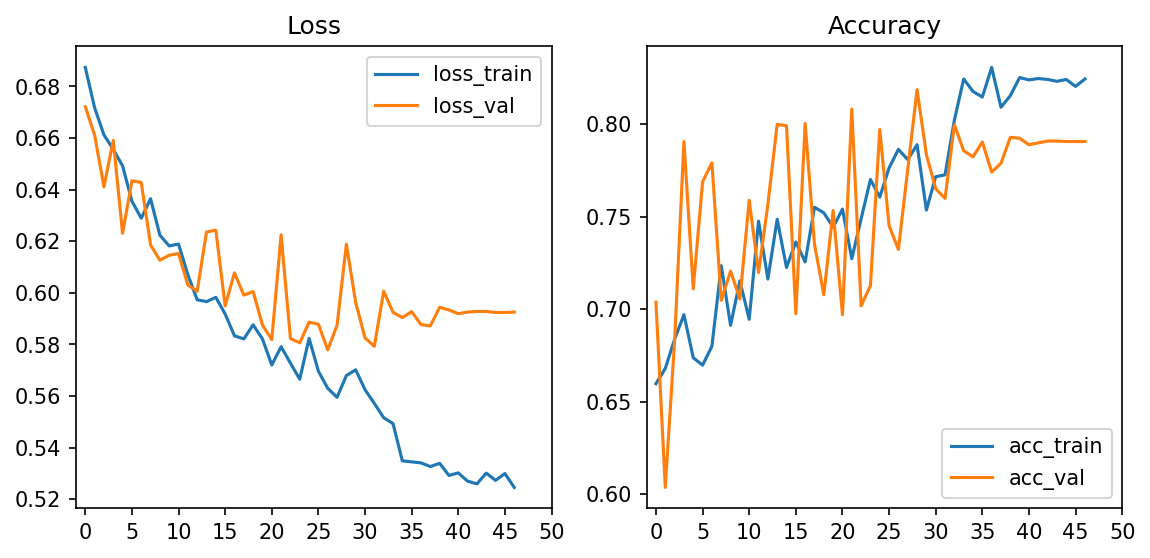

In [14]:
# Plot training and validation loss and accuracy
_, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)
for i, (train_par, val_par) in enumerate(zip([train_loss, train_acc], [val_loss, val_acc])):
    ax[i].plot(train_par)
    ax[i].plot(val_par)
    ax[i].set_xlim(-1, 50)
    ax[i].set_xticks(ticks=[i for i in range(50+1) if i % 5 == 0])
    ax[i].set_title('Accuracy' if i == 1 else 'Loss')
    ax[i].legend(['acc_train', 'acc_val'] if i == 1 else ['loss_train', 'loss_val'])
plt.show()

In [27]:
input_dim

41

Test Accuracy: 0.7127


<Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>

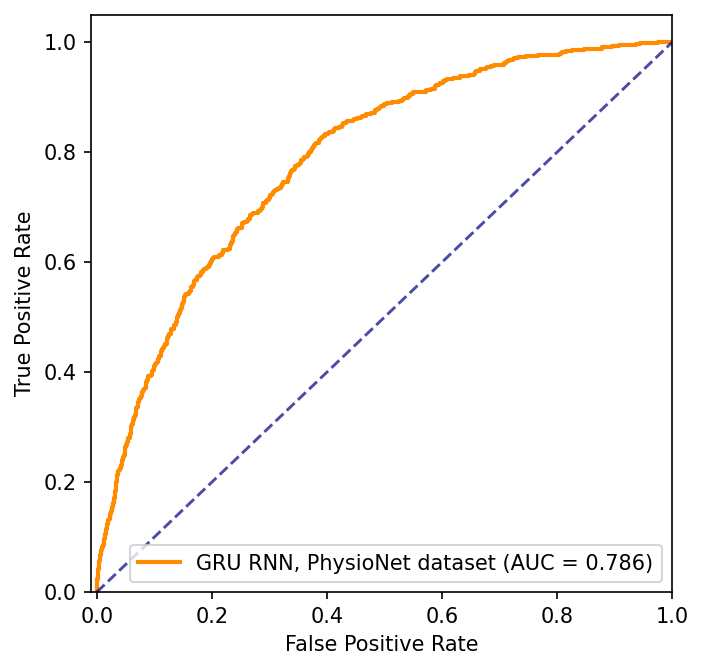

In [15]:
model = MyGRU(input_dim, 64, 2, n_layers=4)
phys_labels, phys_pred, phys_score = best_model_predict(model, 'best_gru_model_physio.pth', test_loader=test_loader)
plot_roc(phys_labels, phys_score, model_name="GRU RNN, PhysioNet dataset", color='darkorange')

In [16]:
# Check model's inference time
def measure_inference_time(model, model_params_path, dataloader, device, is_phys=True,n_runs=100):
    model.load_state_dict(torch.load(model_params_path))
    model = model.to(device)
    model.eval()
    timings = []

    # Measurement
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= n_runs: break
            
            if is_phys:
                data = batch["observed_data"].to(device)
                mask = batch["observed_mask"].to(device)
            else:
                data = batch["image"].to(device)
                mask = None
            
            start_time = time.perf_counter()
            _ = model(data, mask=mask)
            if device == 'cuda:0': torch.cuda.synchronize()
            timings.append(time.perf_counter() - start_time)
    
    return np.mean(timings), np.std(timings)

# Usage
model = MyGRU(input_dim, 64, 2, n_layers=4)
mean_time, std_time = measure_inference_time(model, 'best_gru_model_physio.pth', test_loader, device)
print(f"Inference time: {mean_time*1000:.2f}ms ± {std_time*1000:.2f}ms")

Inference time: 1.69ms ± 0.03ms


In [17]:
# Check the number of the model's parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
model = MyGRU(input_dim, 64, 2, n_layers=4)
print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 103,426


# MNIST data

### Data preparation

In [18]:
class MNISTDataset(Dataset):
    def __init__(self, root, transform, download=True, train=True):
        # Load MNIST data
        self.data = MNIST(
            root=root, 
            train=train, 
            download=download,
            transform=transform
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Reshape for RNN: (1, 28, 28) -> (28, 28)
        image = image.squeeze(0)  # Remove channel dimension
        
        return {'image': image, 'label': label}

# Set image transform function
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST mean and std
])

# Download data
train_mnist_dataset = MNISTDataset(root='./data', train=True, download=False, transform=transform)
test_mnist_dataset = MNISTDataset(root='./data', train=False, download=False, transform=transform)

# Create data loaders
train_mnist_loader = DataLoader(train_mnist_dataset, batch_size=64, shuffle=True)
test_mnist_loader = DataLoader(test_mnist_dataset, batch_size=64, shuffle=False)

In [19]:
# Check data shape
for i in test_mnist_loader:
    print(i['image'].shape)
    break

torch.Size([64, 28, 28])


### Train and validate GRU

In [20]:
# Model parameters
model = MyGRU(28, 64, 10, n_layers=2, double_inp_size=False).to(device)

loss_f = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=3)
earlystop = EarlyStopping(mode='min', patience=4)

In [21]:
EPOCHS = 20
lr_list = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
val_auroc = []
best_val_loss = None
threshold = 0.01

for epoch in range(EPOCHS):
    # Training step
    mean_train_loss, running_train_acc  = train_epoch(model, train_mnist_loader, loss_f, opt, device, epoch, EPOCHS, is_phys=False)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Validation step
    mean_val_loss, running_val_acc, running_val_auroc = validate(model, test_mnist_loader, loss_f, device, is_phys=False)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    val_auroc.append(running_val_auroc)
    
    # Learning rate scheduling
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, val_auroc={running_val_auroc:.4g}, {lr=:.4g}")

    # Save best model
    if best_val_loss is None:
        best_val_loss = mean_val_loss

    if mean_val_loss < best_val_loss - best_val_loss * threshold:
        best_val_loss = mean_val_loss
        torch.save(model.state_dict(), 'best_gru_model_mnist.pth')
        print("Saved best model checkpoint.")

    if earlystop(mean_val_loss):
        print(f"\033[31mTraining stopped on {epoch + 1} epoch.\033[0m")
        break

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/20], train_loss=1.7193, val_loss=1.5284, val_acc=0.9367, val_auroc=0.9953, lr=0.001


Epoch [2/20], train_loss=1.5237, val_loss=1.5050, val_acc=0.9578, val_auroc=0.9976, lr=0.001
Saved best model checkpoint.


Epoch [3/20], train_loss=1.5065, val_loss=1.4948, val_acc=0.9669, val_auroc=0.9986, lr=0.001


Epoch [4/20], train_loss=1.4965, val_loss=1.4883, val_acc=0.9736, val_auroc=0.999, lr=0.001
Saved best model checkpoint.


Epoch [5/20], train_loss=1.4921, val_loss=1.4845, val_acc=0.9768, val_auroc=0.999, lr=0.001


Epoch [6/20], train_loss=1.4877, val_loss=1.4814, val_acc=0.9795, val_auroc=0.9991, lr=0.001


Epoch [7/20], train_loss=1.4857, val_loss=1.4834, val_acc=0.9783, val_auroc=0.9993, lr=0.001


Epoch [8/20], train_loss=1.4839, val_loss=1.4788, val_acc=0.9827, val_auroc=0.9995, lr=0.001


Epoch [9/20], train_loss=1.4808, val_loss=1.4820, val_acc=0.9790, val_auroc=0.9991, lr=0.001


Epoch [10/20], train_loss=1.4799, val_loss=1.4764, val_acc=0.9850, val_auroc=0.9994, lr=0.001


Epoch [11/20], train_loss=1.4784, val_loss=1.4787, val_acc=0.9823, val_auroc=0.9994, lr=0.001


Epoch [12/20], train_loss=1.4775, val_loss=1.4785, val_acc=0.9826, val_auroc=0.9995, lr=0.001


Epoch [13/20], train_loss=1.4762, val_loss=1.4781, val_acc=0.9833, val_auroc=0.9995, lr=0.001


Epoch [14/20], train_loss=1.4751, val_loss=1.4748, val_acc=0.9866, val_auroc=0.9996, lr=0.001


Epoch [15/20], train_loss=1.4752, val_loss=1.4751, val_acc=0.9862, val_auroc=0.9996, lr=0.001


Epoch [16/20], train_loss=1.4747, val_loss=1.4769, val_acc=0.9845, val_auroc=0.9995, lr=0.001


Epoch [17/20], train_loss=1.4742, val_loss=1.4761, val_acc=0.9857, val_auroc=0.9995, lr=0.001


Epoch [18/20], train_loss=1.4742, val_loss=1.4747, val_acc=0.9868, val_auroc=0.9995, lr=0.0001
Training stopped on 18 epoch.


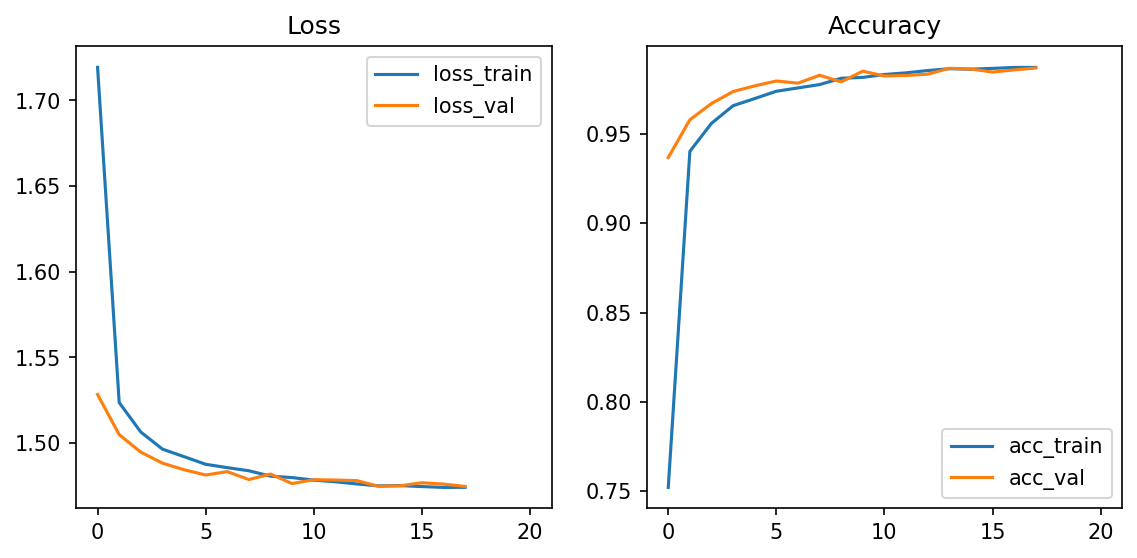

In [22]:
# Plot training and validation loss and accuracy
_, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)
for i, (train_par, val_par) in enumerate(zip([train_loss, train_acc], [val_loss, val_acc])):
    ax[i].plot(train_par)
    ax[i].plot(val_par)
    ax[i].set_xlim(-1, 21)
    ax[i].set_xticks(ticks=[i for i in range(20+1) if i % 5 == 0])
    ax[i].set_title('Accuracy' if i == 1 else 'Loss')
    ax[i].legend(['acc_train', 'acc_val'] if i == 1 else ['loss_train', 'loss_val'])
plt.show()

Test Accuracy: 0.9736
Labels are already binarized


<Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>

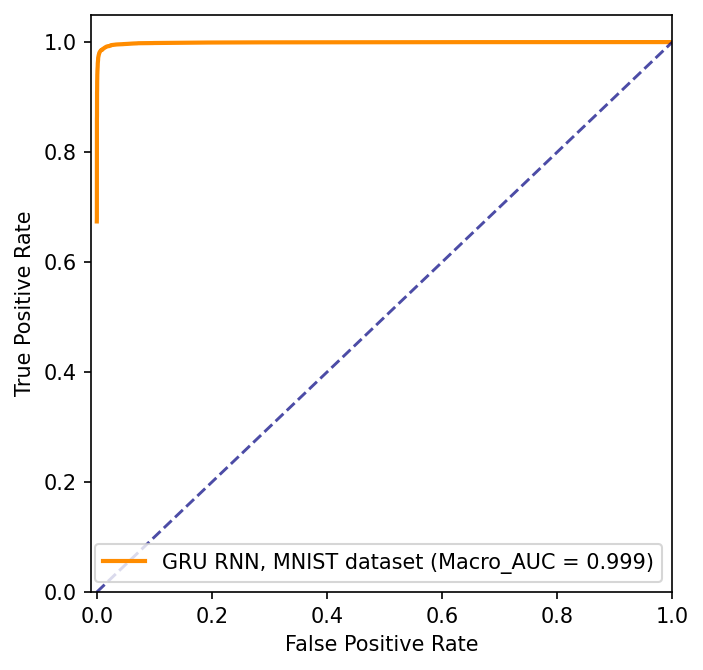

In [23]:
model = MyGRU(28, 64, 10, n_layers=2, double_inp_size=False)
mnist_labels, mnist_pred, mnist_score = best_model_predict(model, 'best_gru_model_mnist.pth', test_loader=test_mnist_loader, is_phys=False)
plot_macro_roc(mnist_labels, mnist_score, model_name="GRU RNN, MNIST dataset", color='darkorange')

In [24]:
# Check model's inference time
def measure_inference_time(model, model_params_path, dataloader, device, is_phys=True,n_runs=100):
    model.load_state_dict(torch.load(model_params_path))
    model = model.to(device)
    model.eval()
    timings = []

    # Measurement
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= n_runs: break
            
            if is_phys:
                data = batch["observed_data"].to(device)
                mask = batch["observed_mask"].to(device)
            else:
                data = batch["image"].to(device)
                mask = None
            
            start_time = time.perf_counter()
            _ = model(data, mask=mask)
            if device == 'cuda:0': torch.cuda.synchronize()
            timings.append(time.perf_counter() - start_time)
    
    return np.mean(timings), np.std(timings)

# Usage
model = MyGRU(28, 64, 10, n_layers=2, double_inp_size=False)
mean_time, std_time = measure_inference_time(model, 'best_gru_model_mnist.pth', test_mnist_loader, device, is_phys=False)
print(f"Inference time: {mean_time*1000:.2f}ms ± {std_time*1000:.2f}ms")

Inference time: 0.49ms ± 0.12ms


In [25]:
# Check the number of the model's parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
model = MyGRU(28, 64, 10, n_layers=2, double_inp_size=False)
print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 43,658


# CIFAR10

### Data preparation

In [55]:
class CIFAR10Dataset(Dataset):
    def __init__(self, root, transform, download=True, train=True):
        # Load MNIST data
        self.data = CIFAR10(
            root=root, 
            train=train, 
            download=download,
            transform=transform
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        # Reshape for RNN: (1, 28, 28) -> (28, 28)
        image = image.squeeze(0)
        
        return {'image': image, 'label': label}

# Set image transform function
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download data
train_cifar_dataset = CIFAR10Dataset(root='./data', train=True, download=True, transform=transform)
test_cifar_dataset = CIFAR10Dataset(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_cifar_loader = DataLoader(train_cifar_dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
test_cifar_loader = DataLoader(test_cifar_dataset, batch_size=64, shuffle=False, num_workers=10, pin_memory=True)

In [56]:
# Check data shape
for i in test_cifar_loader:
    print(i['image'].shape)
    break

torch.Size([64, 32, 32])


### Train and validate GRU

In [57]:
# Model parameters
model = MyGRU(32, 64, 10, n_layers=4, double_inp_size=False).to(device)

loss_f = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=4)
earlystop = EarlyStopping(mode='min', patience=8)

In [58]:
EPOCHS = 30
lr_list = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
val_auroc = []
best_val_loss = None
threshold = 0.01

for epoch in range(EPOCHS):
    # Training step
    mean_train_loss, running_train_acc  = train_epoch(model, train_cifar_loader, loss_f, opt, device, epoch, EPOCHS, is_phys=False)
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # Validation step
    mean_val_loss, running_val_acc, running_val_auroc = validate(model, test_cifar_loader, loss_f, device, is_phys=False)
    val_loss.append(mean_val_loss)
    val_acc.append(running_val_acc)
    val_auroc.append(running_val_auroc)
    
    # Learning rate scheduling
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train_loss={mean_train_loss:.4f}, val_loss={mean_val_loss:.4f}, val_acc={running_val_acc:.4f}, val_auroc={running_val_auroc:.4g}, {lr=:.4g}")

    # Save best model
    if best_val_loss is None:
        best_val_loss = mean_val_loss

    if mean_val_loss < best_val_loss - best_val_loss * threshold:
        best_val_loss = mean_val_loss
        torch.save(model.state_dict(), 'best_gru_model_cifar.pth')
        print("Saved best model checkpoint.")

    if earlystop(mean_val_loss):
        print(f"\033[31mTraining stopped on {epoch + 1} epoch.\033[0m")
        break

Epoch [1/30], train_loss=2.1984, val_loss=2.1634, val_acc=0.2889, val_auroc=0.7233, lr=0.001


Epoch [2/30], train_loss=2.1418, val_loss=2.1220, val_acc=0.3338, val_auroc=0.7436, lr=0.001
Saved best model checkpoint.


Epoch [3/30], train_loss=2.1174, val_loss=2.1042, val_acc=0.3519, val_auroc=0.754, lr=0.001


Epoch [4/30], train_loss=2.1019, val_loss=2.0880, val_acc=0.3681, val_auroc=0.7663, lr=0.001
Saved best model checkpoint.


Epoch [5/30], train_loss=2.0844, val_loss=2.0832, val_acc=0.3713, val_auroc=0.7707, lr=0.001


Epoch [6/30], train_loss=2.0695, val_loss=2.0651, val_acc=0.3915, val_auroc=0.7878, lr=0.001
Saved best model checkpoint.


Epoch [7/30], train_loss=2.0550, val_loss=2.0549, val_acc=0.4017, val_auroc=0.7961, lr=0.001


Epoch [8/30], train_loss=2.0453, val_loss=2.0425, val_acc=0.4112, val_auroc=0.805, lr=0.001
Saved best model checkpoint.


Epoch [9/30], train_loss=2.0317, val_loss=2.0387, val_acc=0.4158, val_auroc=0.8092, lr=0.001


Epoch [10/30], train_loss=2.0218, val_loss=2.0272, val_acc=0.4292, val_auroc=0.8146, lr=0.001


Epoch [11/30], train_loss=2.0108, val_loss=2.0191, val_acc=0.4385, val_auroc=0.8216, lr=0.001
Saved best model checkpoint.


Epoch [12/30], train_loss=2.0036, val_loss=2.0188, val_acc=0.4355, val_auroc=0.8201, lr=0.001


Epoch [13/30], train_loss=1.9971, val_loss=2.0105, val_acc=0.4456, val_auroc=0.8264, lr=0.001


Epoch [14/30], train_loss=1.9912, val_loss=2.0051, val_acc=0.4508, val_auroc=0.8279, lr=0.001


Epoch [15/30], train_loss=1.9842, val_loss=2.0110, val_acc=0.4441, val_auroc=0.8233, lr=0.001


Epoch [16/30], train_loss=1.9767, val_loss=2.0092, val_acc=0.4471, val_auroc=0.8252, lr=0.001


Epoch [17/30], train_loss=1.9718, val_loss=2.0054, val_acc=0.4493, val_auroc=0.8284, lr=0.001


Epoch [18/30], train_loss=1.9672, val_loss=1.9951, val_acc=0.4642, val_auroc=0.8329, lr=0.001
Saved best model checkpoint.


Epoch [19/30], train_loss=1.9617, val_loss=1.9937, val_acc=0.4613, val_auroc=0.8355, lr=0.001


Epoch [20/30], train_loss=1.9598, val_loss=1.9956, val_acc=0.4629, val_auroc=0.8342, lr=0.001


Epoch [21/30], train_loss=1.9552, val_loss=1.9888, val_acc=0.4679, val_auroc=0.8376, lr=0.001


Epoch [22/30], train_loss=1.9505, val_loss=1.9950, val_acc=0.4619, val_auroc=0.834, lr=0.001


Epoch [23/30], train_loss=1.9455, val_loss=1.9795, val_acc=0.4758, val_auroc=0.8422, lr=0.001


Epoch [24/30], train_loss=1.9412, val_loss=1.9820, val_acc=0.4756, val_auroc=0.8393, lr=0.001


Epoch [25/30], train_loss=1.9378, val_loss=1.9800, val_acc=0.4782, val_auroc=0.8424, lr=0.001


Epoch [26/30], train_loss=1.9340, val_loss=1.9827, val_acc=0.4729, val_auroc=0.8426, lr=0.001


Epoch [27/30], train_loss=1.9322, val_loss=1.9693, val_acc=0.4871, val_auroc=0.8473, lr=0.001
Saved best model checkpoint.


Epoch [28/30], train_loss=1.9278, val_loss=1.9698, val_acc=0.4873, val_auroc=0.846, lr=0.001


Epoch [29/30], train_loss=1.9274, val_loss=1.9749, val_acc=0.4837, val_auroc=0.8446, lr=0.001


Epoch [30/30], train_loss=1.9235, val_loss=1.9732, val_acc=0.4833, val_auroc=0.8449, lr=0.001


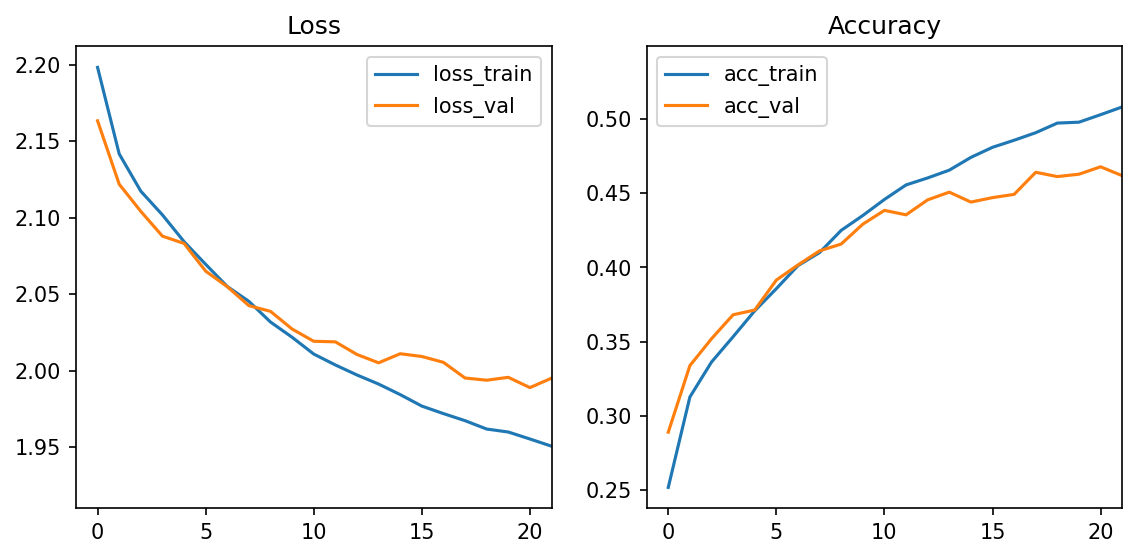

In [59]:
# Plot training and validation loss and accuracy
_, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)
for i, (train_par, val_par) in enumerate(zip([train_loss, train_acc], [val_loss, val_acc])):
    ax[i].plot(train_par)
    ax[i].plot(val_par)
    ax[i].set_xlim(-1, 21)
    ax[i].set_xticks(ticks=[i for i in range(20+1) if i % 5 == 0])
    ax[i].set_title('Accuracy' if i == 1 else 'Loss')
    ax[i].legend(['acc_train', 'acc_val'] if i == 1 else ['loss_train', 'loss_val'])
plt.show()

Test Accuracy: 0.4871
Labels are already binarized


<Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>

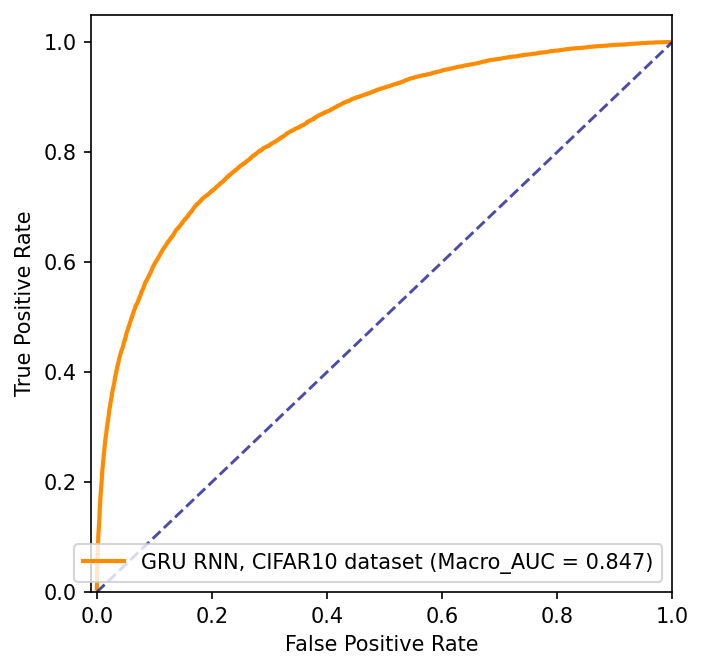

In [61]:
model = MyGRU(32, 64, 10, n_layers=4, double_inp_size=False)
cifar_labels, cifar_pred, cifar_score = best_model_predict(model, 'best_gru_model_cifar.pth', test_loader=test_cifar_loader, is_phys=False)
plot_macro_roc(cifar_labels, cifar_score, model_name="GRU RNN, CIFAR10 dataset", color='darkorange')

In [70]:
# Check model's inference time
def measure_inference_time(model, model_params_path, dataloader, device, is_phys=True,n_runs=100):
    model.load_state_dict(torch.load(model_params_path))
    model = model.to(device)
    model.eval()
    timings = []

    # Measurement
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= n_runs: break
            
            if is_phys:
                data = batch["observed_data"].to(device)
                mask = batch["observed_mask"].to(device)
            else:
                data = batch["image"].to(device)
                mask = None
            
            start_time = time.perf_counter()
            _ = model(data, mask=mask)
            if device == 'cuda:0': torch.cuda.synchronize()
            timings.append(time.perf_counter() - start_time)
    
    return np.mean(timings), np.std(timings)

# Usage
model = MyGRU(32, 64, 10, n_layers=4, double_inp_size=False)
mean_time, std_time = measure_inference_time(model, 'best_gru_model_cifar.pth', test_cifar_loader, device, is_phys=False)
print(f"Inference time: {mean_time*1000:.2f}ms ± {std_time*1000:.2f}ms")

Inference time: 0.83ms ± 0.25ms


In [71]:
# Check the number of the model's parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Usage
model = MyGRU(32, 64, 10, n_layers=4, double_inp_size=False)
print(f"Trainable parameters: {count_parameters(model):,}")

Trainable parameters: 94,346


Labels are already binarized
Labels are already binarized


<Axes: xlabel='False Positive Rate', ylabel='True Positive Rate'>

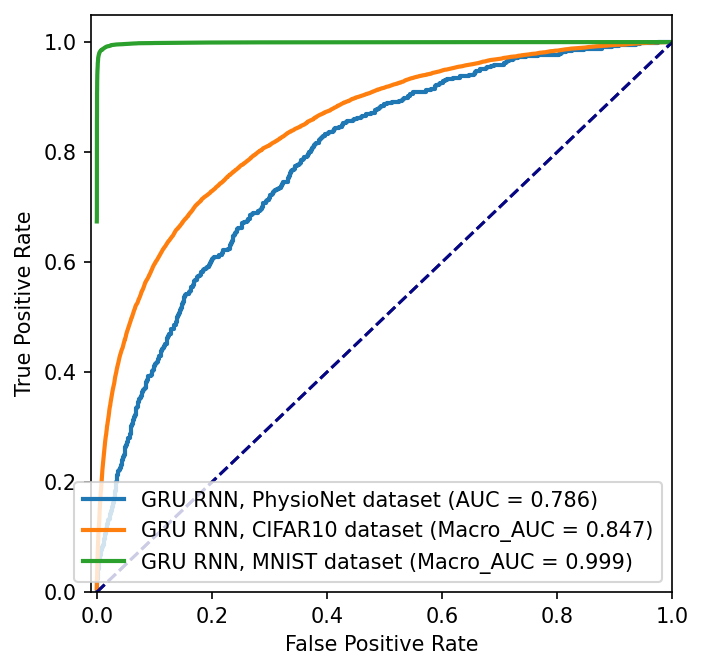

In [72]:
_, ax = plt.subplots(figsize=(5,5), dpi=150)

plot_roc(phys_labels, phys_score, model_name="GRU RNN, PhysioNet dataset", ax=ax)
plot_macro_roc(cifar_labels, cifar_score, model_name="GRU RNN, CIFAR10 dataset", ax=ax)
plot_macro_roc(mnist_labels, mnist_score, model_name="GRU RNN, MNIST dataset", ax=ax)